intensity_threshold = 0.6
band_threshold = 0.6
band_bounds=(0.05,2.5)
opening_size=5
dilation_size = 3
corr_threshold = 0.8

In [1]:
import sys
from pathlib import Path
import os
import warnings
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
sys.path.append(SPIKECOUNTER_PATH)
import matplotlib as mpl
from matplotlib import patches, colors
import colorcet as cc
from cycler import cycler

import numpy as np
import skimage.io as skio
from scipy import ndimage, signal, stats, fft, interpolate, optimize
from scipy.io import savemat
from skimage import exposure, measure, filters, transform, morphology
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import mat73
import pandas as pd
import parse
import pickle

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils
import seaborn as sns


warnings.filterwarnings("once")
biopubs_style = os.path.join(SPIKECOUNTER_PATH, "config", "bio_publications.mplstyle")
plt.style.use(
    biopubs_style
)
ss = StandardScaler()

In [2]:
expt_name = "20220222_frgeco_nkx_widefield"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure1/", expt_name)
os.makedirs(output_datadir, exist_ok=True)
subfolder = "corrected"

In [53]:
fs=10.2
start_hpf = 19.5
expt_info = utils.process_experiment_metadata(pd.read_csv(Path(rootdir,"analysis", subfolder, "experiment_data.csv")))
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600

### Load segmented traces

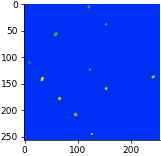

In [4]:
segmentation_mask = skio.imread(rootdir/subfolder/"analysis/segmentation_video.tif")
roi_map = np.median(segmentation_mask, axis=0)
roi_map = roi_map[np.arange(roi_map.shape[0], step=2),:]
roi_map = roi_map[:,np.arange(roi_map.shape[1], step=2)]
plt.imshow(roi_map)

In [28]:
def custom_lp_filter(raw, norm_thresh=0.5):
    b, a = signal.butter(5, norm_thresh)
    intensity = signal.filtfilt(b, a, raw)
    mean_freq = 2.0
    b, a = signal.butter(5, [mean_freq-0.2, mean_freq+0.2], btype="bandstop", fs=10.2)
    intensity = signal.filtfilt(b, a, intensity)
    return intensity

def custom_bp_filter(raw):
    but = signal.butter(7, (0.1, 2), btype="bandpass", output="sos", fs=fs)
    intensity = signal.sosfiltfilt(but, raw)
    return intensity

In [54]:
dobj = traces.TimelapseArrayExperiment(os.path.join(rootdir, subfolder, "analysis"),start_hpf, fs)

In [55]:
timepoints = np.arange(3, 120)
dobj.load_traces(timepoints=np.arange(1, expt_info.shape[0], dtype=int),
                 per_trace_start=0, pb_window=401, corr_photobleach=False, filter_function=custom_bp_filter)

NameError: name 'nkx' is not defined

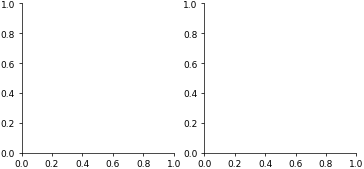

In [56]:
# np.argwhere(dobj.block_metadata["offset"].to_numpy() > 4000).ravel()[0]
outdir = "/n/cohen_lab/Lab/Papers/First Heartbeat/Supplementary Figures/S1"
fig1, axes = plt.subplots(1,2, figsize=(6,2.75))
axes[0].imshow(nkx, cmap="gray")
visualize.plot_img_scalebar(fig1, axes[0], 400, 450, 500, 10, pix_per_um = (1/2.25)/4, text_pos="above", scale=1)
visualize.display_roi_overlay(nkx, activity, ax=axes[1])
axes[0].set_axis_off()
axes[1].set_axis_off()
plt.tight_layout()
plt.savefig(os.path.join(outdir, "activity_overlap.tif"), dpi=300)

In [57]:
dobj.analyze_peaks(threshold=0.0075, prominence="snr", auto_prom_scale=3.2, auto_thresh_scale=0.4, \
                   wlen=20, min_width=3, max_width=30, baseline_duration=800, baseline_start=500,\
                  excl=1000)

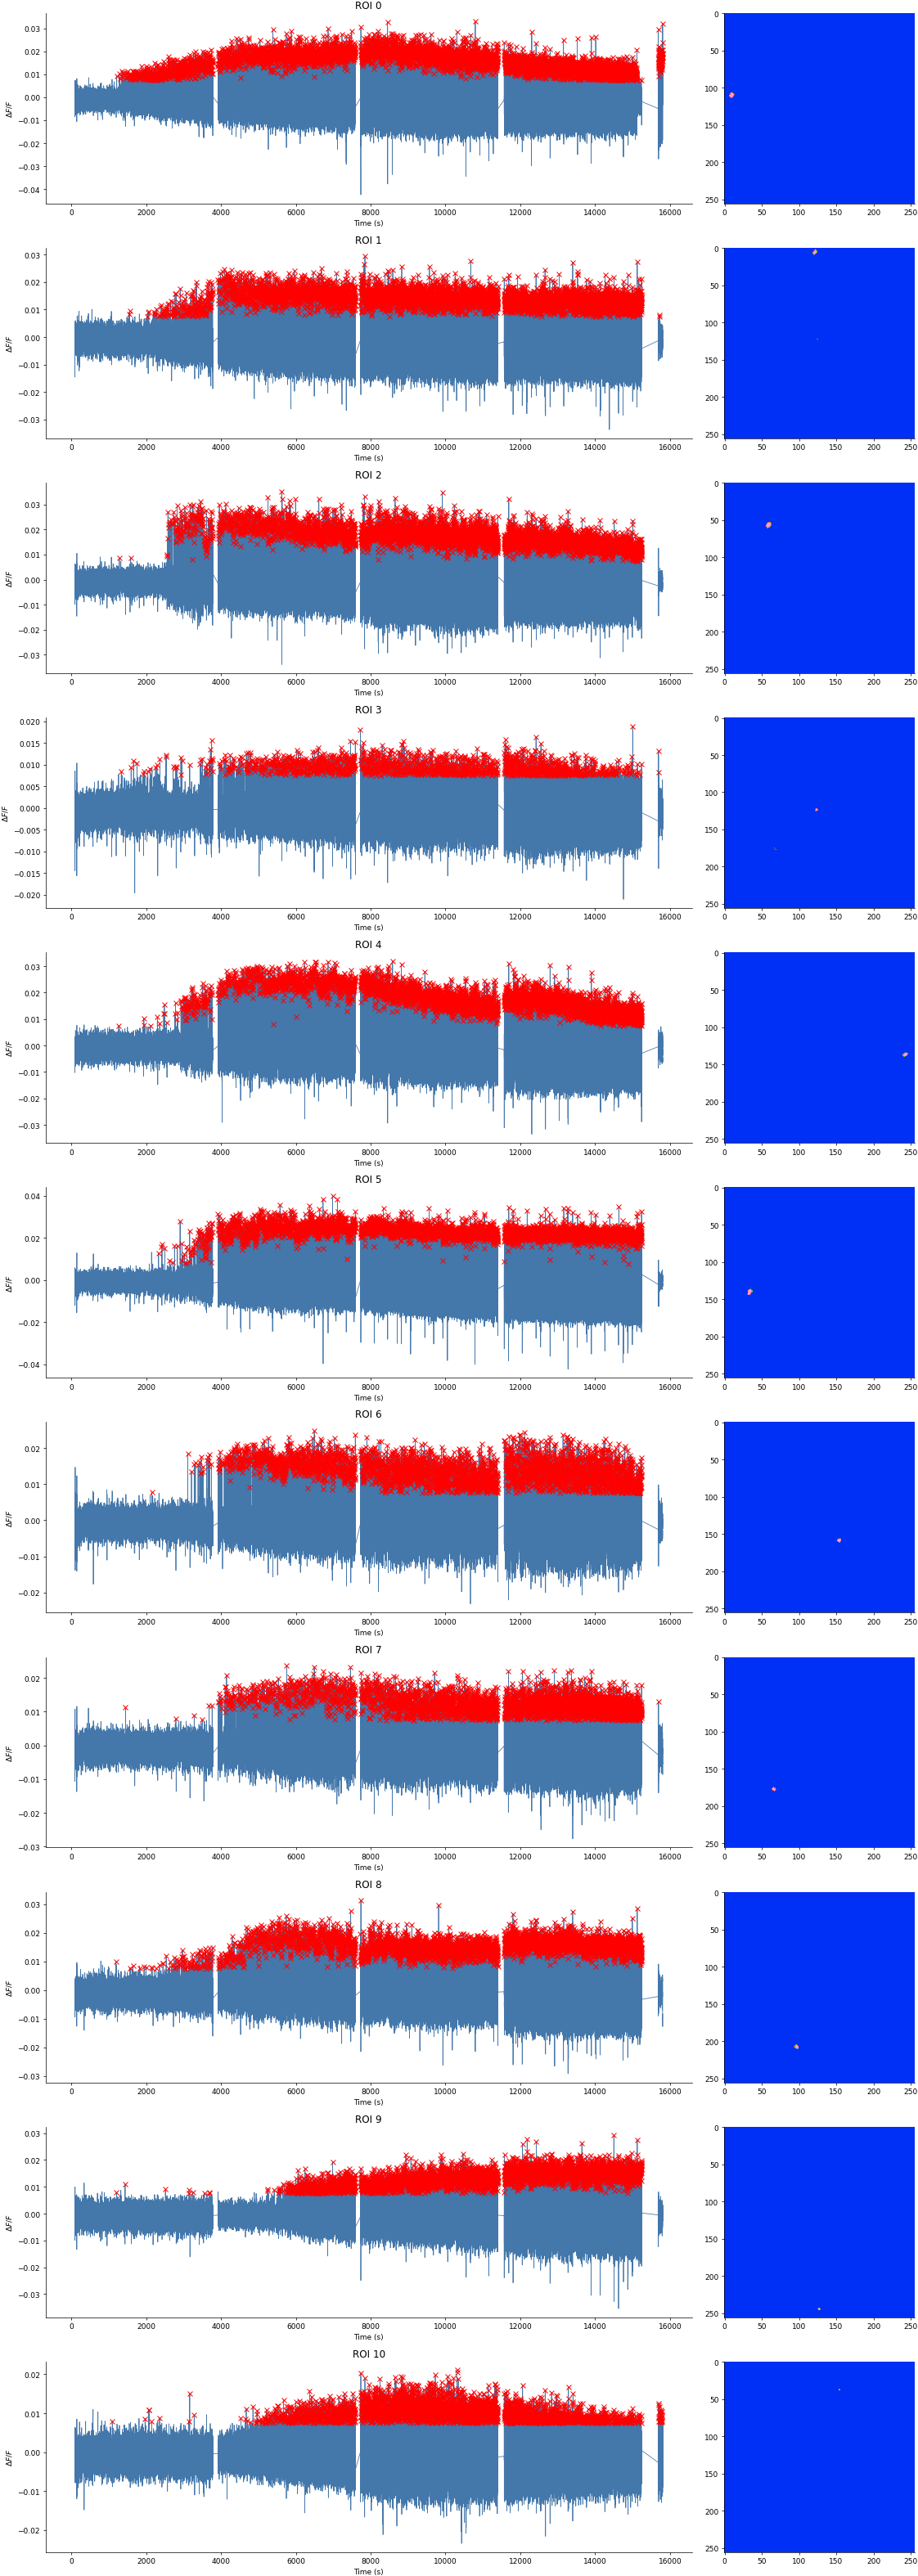

In [58]:
plt.close("all")
fig1, axes = dobj.plot_spikes_with_mask(roi_map, time="s")
plt.savefig(os.path.join(rootdir, "analysis", "spikeplots.svg"))

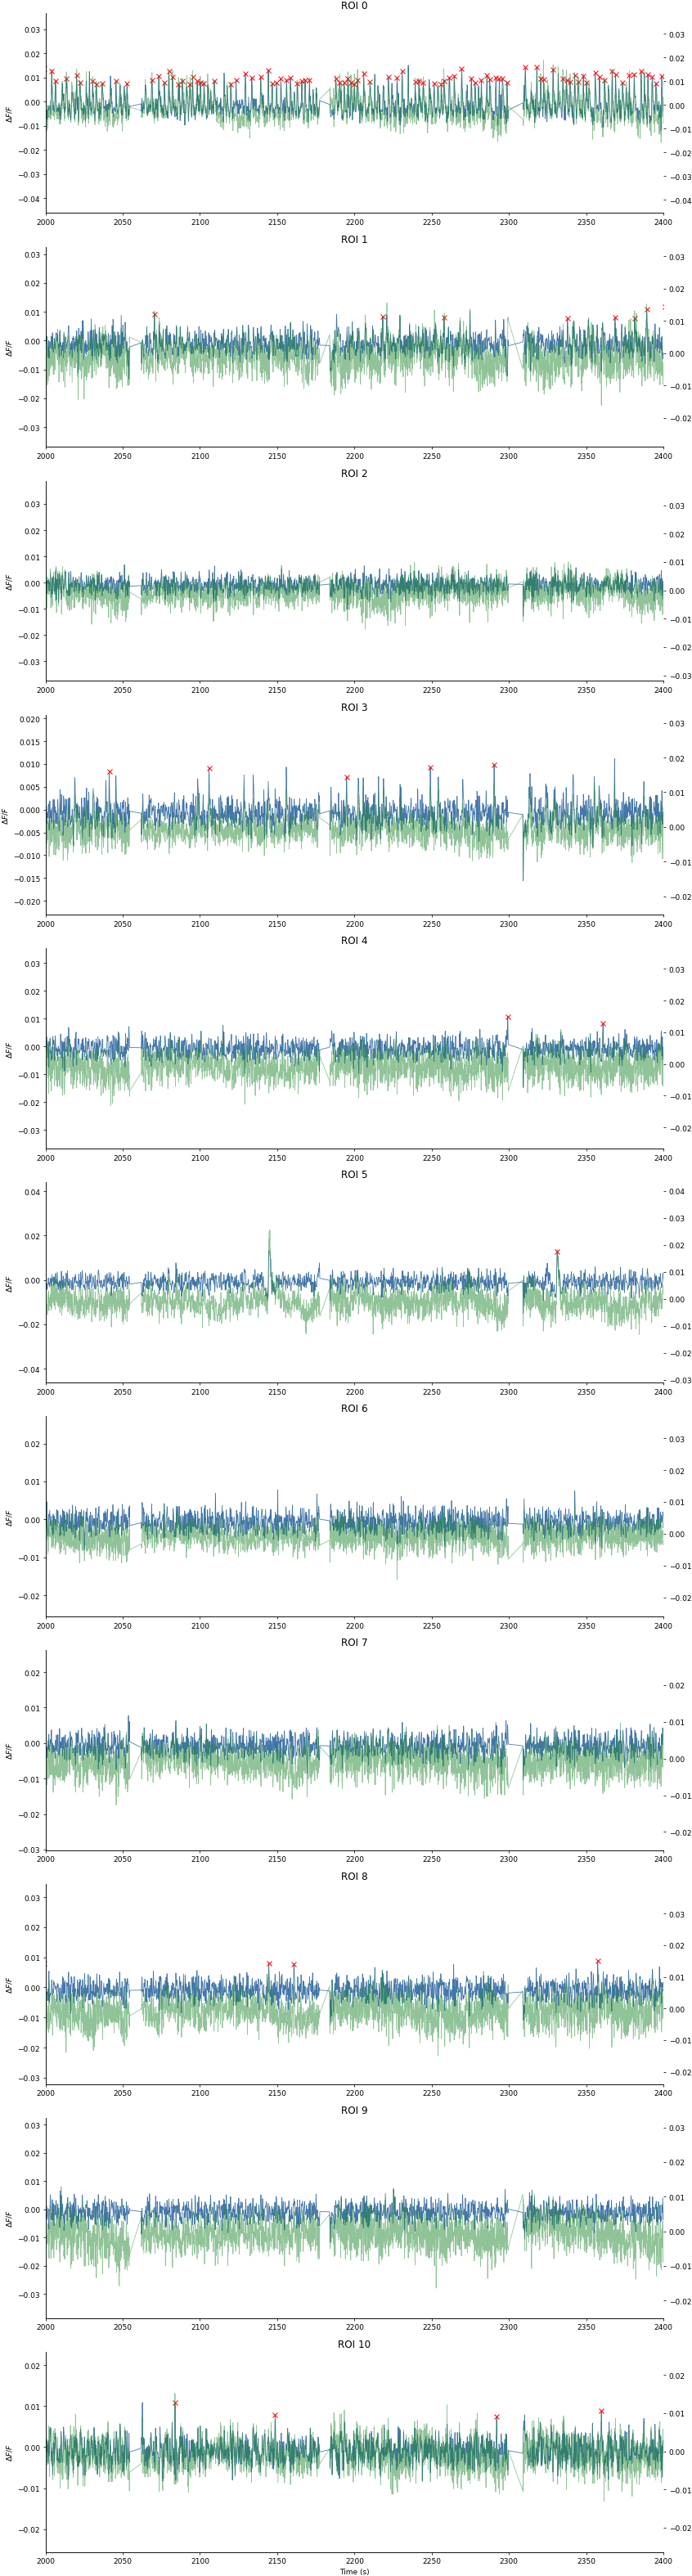

In [38]:
plt.close("all")
fig1, axes = dobj.plot_spikes(np.arange(dobj.dFF.shape[0]), show_unfiltered=True)
for ax in axes:
    ax.set_xlim(2000,2400)

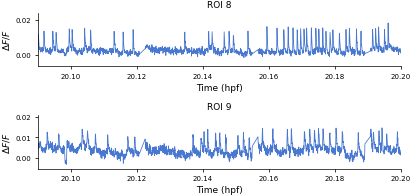

In [108]:
outdir = "/n/cohen_lab/Lab/Papers/First Heartbeat/Supplementary Figures/S1"
rois = [7,8]
n_cols=1
figsize=[6,1.5]
n_rows = int(np.ceil(len(rois)/n_cols))
fig1, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1]*n_rows), squeeze=False)
axes = axes.ravel()
t, _ = dobj._get_time("hpf")

for idx, ax in enumerate(axes):
    roi = rois[idx]
    ax.plot(t, dobj.dFF[roi,:])
    ax.set_xlabel("Time (hpf)")
    ax.set_ylabel(r"$\Delta F/F$")
    ax.set_title("ROI %d" % (roi+1), fontsize=9)
    ax.set_xlim(20.09,20.2)
plt.tight_layout()
plt.savefig(os.path.join(outdir, "example_traces.svg"))

In [41]:
rois = [0, 2, 4, 5, 6, 7]

## Align embryos according to time of first spike

First try criterion based on interspike intervals

In [59]:
offset_times = []
isi_threshold = 120
for idx, roi in enumerate(rois):
    roi_data = dobj.peaks_data.loc[roi]
#     print(roi_data["isi"].to_numpy() < isi_threshold)
    isi = roi_data["isi"].to_numpy()
    offset_idx = np.argwhere((isi< isi_threshold)&(np.roll(isi, 1) < isi_threshold)).ravel()[0]
    offset_times.append(roi_data["t"].iloc[offset_idx])

In [60]:
dobj.peaks_data.loc[rois].to_csv(os.path.join(output_datadir, "peaks_data.csv"))

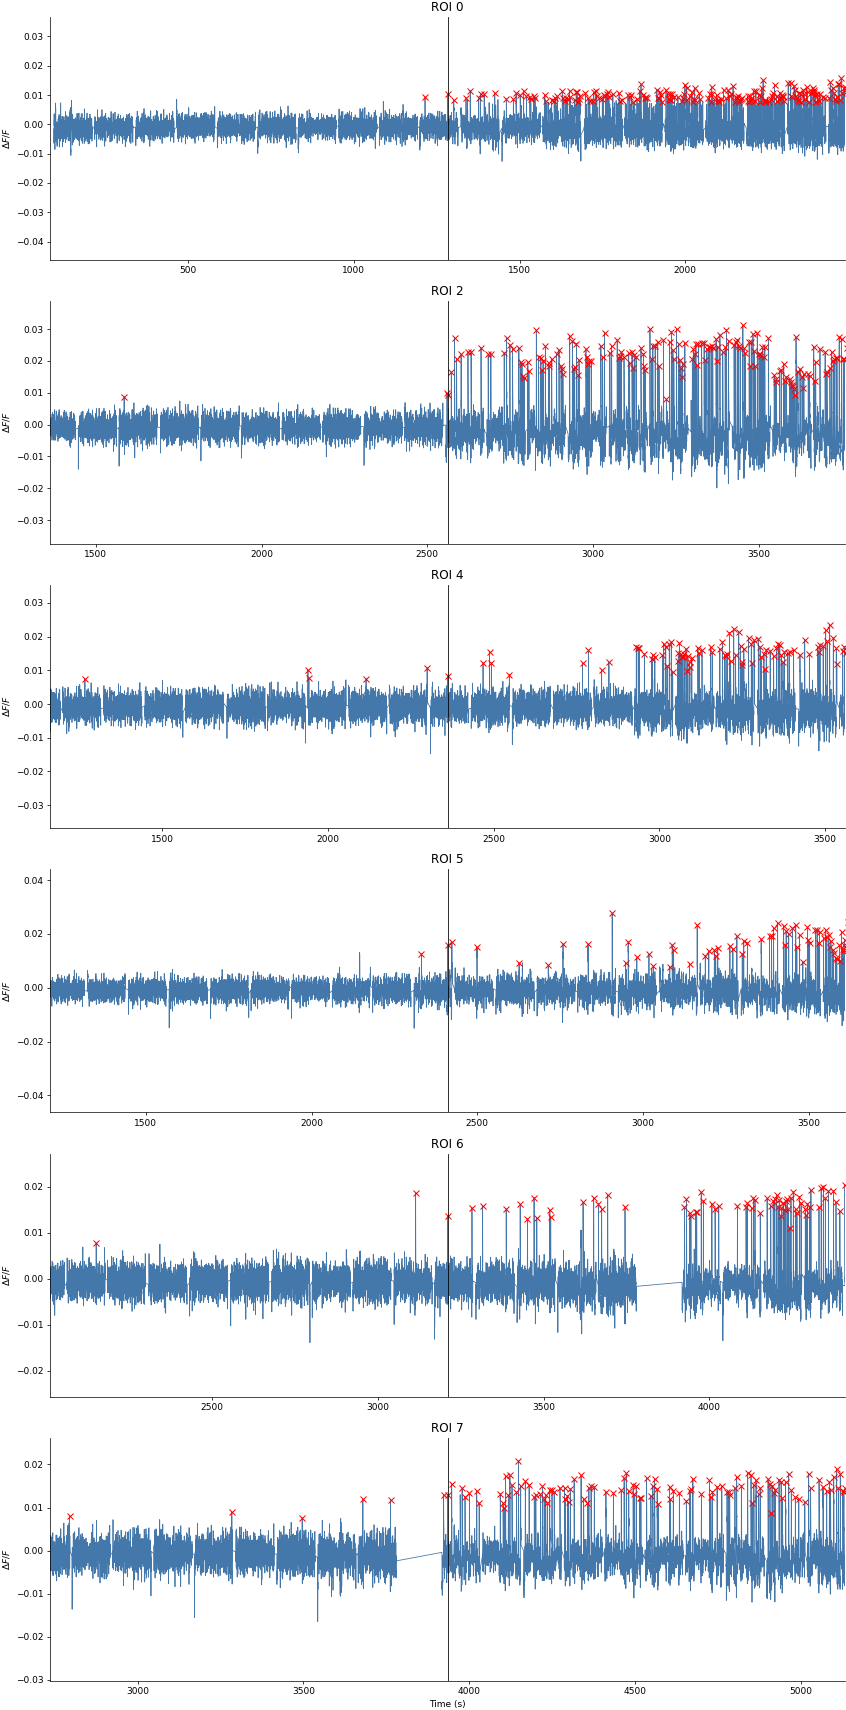

In [61]:
fig1, axes = dobj.plot_spikes(rois)
half_window = 1200
for idx, roi in enumerate(rois):
    axes[idx].set_xlim((offset_times[idx]-half_window, offset_times[idx]+half_window))
    axes[idx].axvline(offset_times[idx], color="black")

### Look at correlation of images to mean trace around transition

In [57]:
half_window = 1800
files_to_analyze = {}
timepoints = []
for roi, offset in enumerate(offset_times):
    first_idx = np.argwhere(expt_info["offset"].to_numpy()>(offset-half_window)).ravel()[0]-1
    if first_idx < 0:
        first_idx = 0
    last_idx = np.argwhere(expt_info["offset"].to_numpy()>(offset+half_window)).ravel()[0]
    if last_idx > expt_info.shape[0]:
        last_idx = expt_info.shape[0]
    
    files_to_analyze[roi] = expt_info["file_name"].iloc[first_idx:last_idx].to_numpy()
    timepoints.append(expt_info["offset"].iloc[first_idx:last_idx].to_numpy())
unique_files = sorted(list(set(np.concatenate(list(files_to_analyze.values())))))
unique_timepoints = sorted(list(set(np.concatenate(timepoints))))

In [59]:
correlation_data = {}
correlation_data["overlay_images"] = {}
correlation_data["correlations"] = {}
correlation_data["traces"] = {}
correlation_data["t_offsets"] = {}
for roi in files_to_analyze.keys():
    correlation_data["overlay_images"][roi] = []
    correlation_data["correlations"][roi] = []
    correlation_data["traces"][roi] = []
    correlation_data["t_offsets"][roi] = []

In [60]:
bbox_offset=25
for idx, f in enumerate(unique_files):
    mask = skio.imread(os.path.join(rootdir, "analysis", "automasks", "%s_mask.tif" % f))
    mean_trace_data = pd.read_csv(os.path.join(rootdir, "analysis", "%s_traces.csv" % f)).set_index("region")
    
    bboxes = [p["bbox"] for p in measure.regionprops(mask)]
    rois_to_check = []
    
    for roi in files_to_analyze.keys():
        if f in files_to_analyze[roi]:
            rois_to_check.append(roi)
    print(f, rois_to_check)
    img = skio.imread(os.path.join(rootdir, "%s.tif" % f))
    mean_img = img.mean(axis=0)
    for roi in rois_to_check:
        trace = mean_trace_data.loc[roi]["mean_intensity"].to_numpy()
        bbox = bboxes[roi]
        r1 = max(bbox[0]-bbox_offset, 0)
        c1 = max(bbox[1]-bbox_offset, 0)
        r2 = min(bbox[2]+bbox_offset, mask.shape[0])
        c2 = min(bbox[3]+bbox_offset, mask.shape[1])
        
        cropped_img = img[:,r1:r2,c1:c2]
        corrs = np.apply_along_axis(lambda x: stats.pearsonr(trace, \
                                                             x)[0], 0, cropped_img)
        correlation_data["correlations"][roi].append(corrs)
        correlation_data["overlay_images"][roi].append(mean_img[r1:r2,c1:c2])
        correlation_data["t_offsets"][roi].append(unique_timepoints[idx]-\
                                                  offset_times[np.argwhere(rois==roi).ravel()[0]])
        correlation_data["traces"][roi].append(trace)
    with open(os.path.join(rootdir, "analysis", "correlation_data.pickle"), "wb") as data_file:
        pickle.dump(correlation_data, data_file)
    del img

072442_p1_t1_p1_z1 [4]
072642_p1_t2_p1_z1 [4]
072842_p1_t3_p1_z1 [4]
073042_p1_t4_p1_z1 [4]
073241_p1_t5_p1_z1 [4]
073440_p1_t6_p1_z1 [4]
073640_p1_t7_p1_z1 [4]
073839_p1_t8_p1_z1 [4]
074039_p1_t9_p1_z1 [4]
074238_p1_t10_p1_z1 [4]
074438_p1_t11_p1_z1 [4]
074637_p1_t12_p1_z1 [4]
074837_p1_t13_p1_z1 [4]
075036_p1_t14_p1_z1 [4]
075236_p1_t15_p1_z1 [2, 4, 9]
075435_p1_t16_p1_z1 [2, 4, 9, 15]
075635_p1_t17_p1_z1 [2, 4, 9, 15]
075834_p1_t18_p1_z1 [2, 4, 9, 15]
080034_p1_t19_p1_z1 [2, 4, 9, 15]
080233_p1_t20_p1_z1 [1, 2, 4, 6, 9, 15]
080433_p1_t21_p1_z1 [1, 2, 4, 5, 6, 9, 10, 12, 15]
080632_p1_t22_p1_z1 [1, 2, 4, 5, 6, 9, 10, 12, 15]
080832_p1_t23_p1_z1 [1, 2, 4, 5, 6, 9, 10, 12, 15]
081031_p1_t24_p1_z1 [1, 2, 4, 5, 6, 9, 10, 12, 15]
081231_p1_t25_p1_z1 [1, 2, 4, 5, 6, 9, 10, 12, 14, 15]
081430_p1_t26_p1_z1 [0, 1, 2, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15]
081630_p1_t27_p1_z1 [0, 1, 2, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15]
081829_p1_t28_p1_z1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]
082029

In [53]:
with open(os.path.join(rootdir, "analysis", "correlation_data.pickle"), "rb") as data_file:
    correlation_data = pickle.load(data_file)

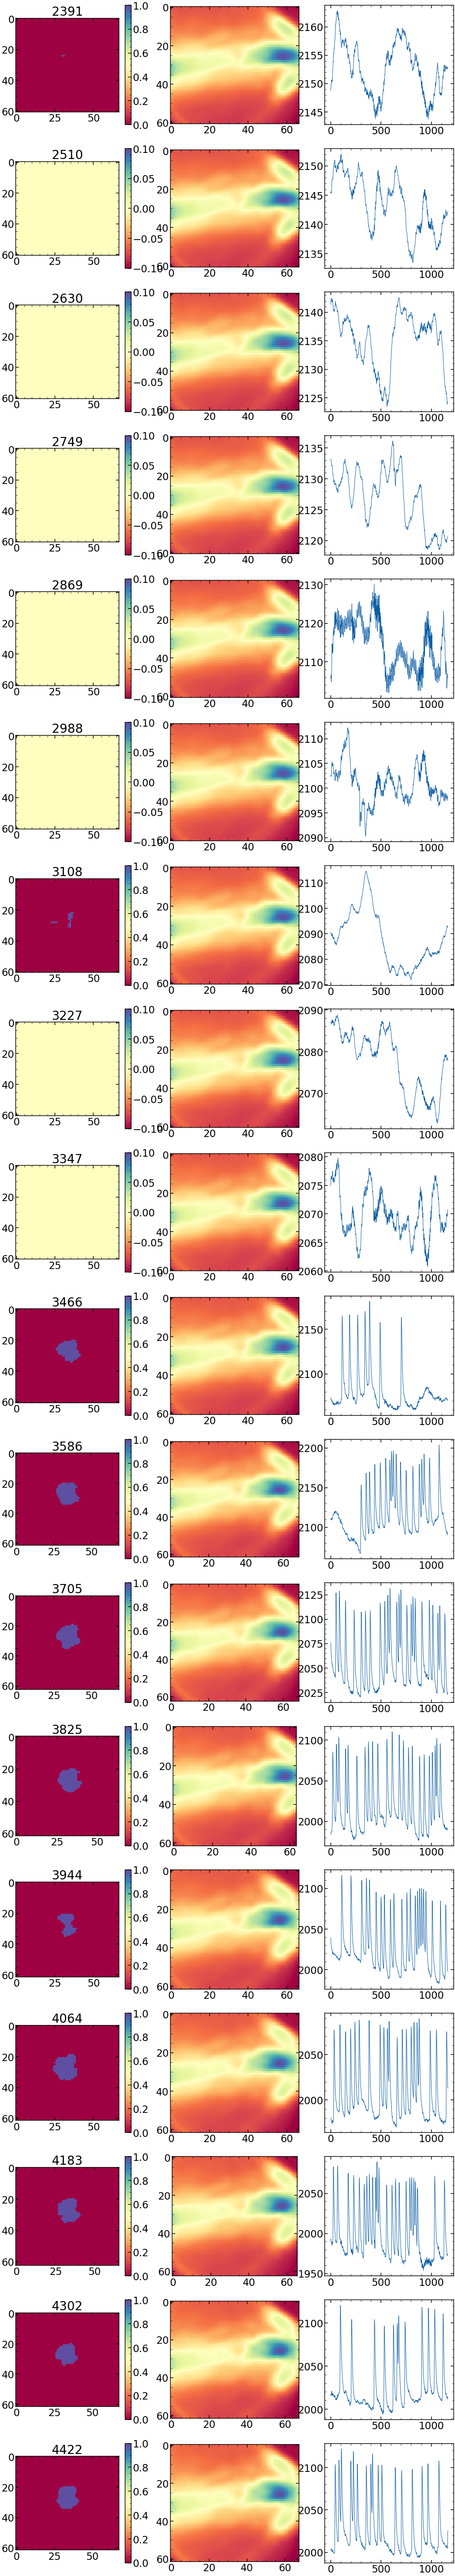

In [35]:
roi = 2
plt.close("all")
roi_overlay_images = correlation_data["overlay_images"][roi]
roi_correlations = correlation_data["correlations"][roi]
roi_offsets = correlation_data["t_offsets"][roi]
roi_traces = correlation_data["traces"][roi]

fig1, axes = plt.subplots(len(roi_overlay_images), 3, figsize=(18, 6*len(roi_overlay_images)))
for i in range(len(roi_overlay_images)):
    plotimg = axes[i,0].imshow(roi_correlations[i] > 0.95)
    plt.colorbar(plotimg, ax=axes[i,0])
    axes[i,1].imshow(roi_overlay_images[i])
    axes[i,0].set_title(roi_offsets[i])
    axes[i,2].plot(roi_traces[i])

In [61]:
correlation_data["correlated_size"] = {}
for roi in correlation_data["traces"].keys():
    correlation_data["correlated_size"][roi] = [np.sum(rc > 0.95) for rc in correlation_data["correlations"][roi]]

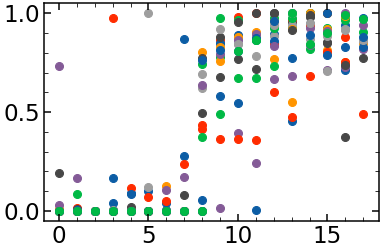

In [42]:
fig1, ax1 = plt.subplots(figsize=(6,4))
for roi in correlation_data["correlated_size"].keys():
    x = np.arange(len(correlation_data["correlated_size"][roi]))
    ax1.scatter(x, correlation_data["correlated_size"][roi]/np.max(correlation_data["correlated_size"][roi]))

In [56]:
with open(os.path.join(rootdir, "analysis", "correlation_data.pickle"), "wb") as data_file:
    pickle.dump(correlation_data, data_file)

### Check frequency change over developmental time for selected embryos

In [62]:
window_size=1800
droi, dsta, dststd = dobj.get_windowed_peak_stats(window_size, overlap=0.9, sta_bounds=None, isi_stat_min_peaks=6)

/n/home11/bjia/SpikeCounter/spikecounter/analysis/traces.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  roi_spike_stats["n_peaks"]


Text(0, 0.5, 'Mean spike frequency (Hz)')

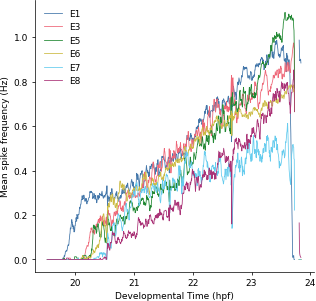

In [63]:
fig1, ax1 = plt.subplots(figsize=(5,5))
for roi in rois:
    e_data = droi.loc[roi]
    ax1.plot(e_data["hpf"], e_data["mean_freq"], label= "E%d" % (roi+1))
ax1.legend()
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel("Mean spike frequency (Hz)")

This one performs better I think.

In [64]:
all_offsets = []
for idx, roi in enumerate(rois):
    e_data = droi.loc[roi]
    hpf = np.array(e_data["hpf"])
    all_offsets.append(np.argwhere(e_data["offset"].to_numpy() >= offset_times[idx]).ravel()[0])

/tmp/ipykernel_33849/1530080871.py:34: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_33849/1530080871.py:44: RuntimeWarning: Mean of empty slice
  "mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf, \


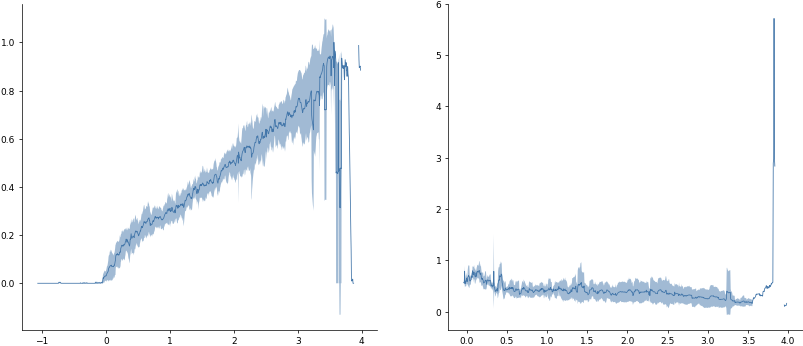

In [68]:
hpf = np.array(droi.loc[0]["hpf"])
hpf_offsets = hpf[all_offsets]
dt = hpf[1] - hpf[0]
aligned_frequencies = np.nan*np.ones((len(rois), \
                                      hpf.shape[0]+max(all_offsets)))
aligned_proms = np.zeros((len(rois), hpf.shape[0]+max(all_offsets)))
aligned_covs = np.nan*np.ones((len(rois), \
                                      hpf.shape[0]+max(all_offsets)))
unaligned_frequencies = np.zeros((len(rois), hpf.shape[0]))
unaligned_covs = np.zeros((len(rois), hpf.shape[0]))
unaligned_proms = np.zeros((len(rois), hpf.shape[0]))
curr_row = 0
for roi in rois:
        e_data = droi.loc[roi]
        mean_freq = np.array(e_data["mean_freq"])
        cov = np.array(e_data["std_isi"]/e_data["mean_isi"])
        mean_prom = np.array(e_data["mean_prom"])
#         print(mean_freq.shape)
#         mean_freq = signal.filtfilt(b,a, mean_freq)
        start_idx = aligned_frequencies.shape[1] - e_data["hpf"].shape[0] - all_offsets[curr_row]
        
        unaligned_frequencies[curr_row, :] = mean_freq
        unaligned_proms[curr_row, :] = mean_prom
        unaligned_covs[curr_row,:] = cov
        
        aligned_frequencies[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = \
            mean_freq
        aligned_proms[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = mean_prom
        aligned_covs[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = cov
        
        curr_row +=1
fig1, axes = plt.subplots(1,2, figsize=(14,6))
ts = (np.arange(aligned_frequencies.shape[1])-(aligned_frequencies.shape[1] - e_data["hpf"].shape[0]))*dt
mean_freq = np.nanmean(aligned_frequencies, axis=0)
mean_cv = np.nanmean(aligned_covs, axis=0)
std_freq = np.nanstd(aligned_frequencies, axis=0)
std_cv = np.nanstd(aligned_covs, axis=0)
axes[0].plot(ts, mean_freq)
axes[1].plot(ts, mean_cv)
axes[0].fill_between(ts, mean_freq-std_freq, mean_freq+std_freq, alpha=0.5)
axes[1].fill_between(ts, mean_cv-std_cv, mean_cv+std_cv, alpha=0.5)
moments = {"idx_offsets": all_offsets, \
            "all_freqs":unaligned_frequencies, "all_freqs_aligned":aligned_frequencies, \
            "mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf, \
            "proms": unaligned_proms, "proms_aligned": aligned_proms, "covs":unaligned_covs, "covs_aligned": aligned_covs,
                                                          "aligned_time_hpf": ts}
savemat(os.path.join(output_datadir, "all_moments.mat"), moments)

In [69]:
all_offsets = moments["idx_offsets"]
hpf = moments["hpf"].ravel()
print(all_offsets)
print(len(hpf))
moments["hpf_start"] = hpf[all_offsets].tolist()

[68, 140, 129, 132, 177, 218]
881


In [70]:
hpf_starts = moments["hpf_start"]

In [73]:
hpf_start = pd.DataFrame({"experiment": [expt_name]*len(hpf_starts), 
             "condition": ["frgeco"]* len(hpf_starts),
             "embryo": np.arange(len(hpf_starts)),
             "start_hpf": hpf_starts})


In [74]:
hpf_start.to_csv(output_datadir/"start_hpfs.csv", index=False)

/tmp/ipykernel_112044/361440658.py:4: RuntimeWarning: Mean of empty slice
  ax1.plot(t, np.nanmean(aligned_frequencies, axis=0))


(0.0, 0.1)

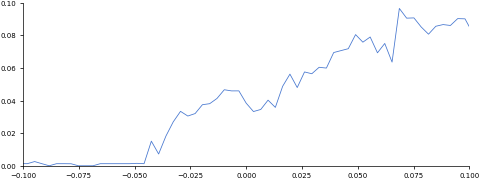

In [40]:
fig1, ax1 = plt.subplots(figsize=(8,3))
dt = hpf[1]-hpf[0]
t = (np.arange(aligned_frequencies.shape[1])-np.max(all_offsets))*dt 
ax1.plot(t, np.nanmean(aligned_frequencies, axis=0))
ax1.set_xlim(-0.1,0.1)
ax1.set_ylim(0, 0.1)

In [42]:
dobj.peaks_data.to_csv(os.path.join(rootdir, "analysis", "peaks_data.csv"))

In [43]:
savemat(os.path.join(rootdir, "analysis", "dFFs.mat"), {"rois": rois, "offset_times": offset_times, "f_s": fs, "dFF": dobj.dFF})

In [44]:
droi, dsta, dststd = dobj.get_windowed_peak_stats(6120, overlap=0.9, sta_before=0, sta_after=0, isi_stat_min_peaks=6)
# droi.to_csv(os.path.join(data_dir, "cx43mo_cv.csv"))

In [45]:
hpf_new = np.array(droi.loc[1]["hpf"])
edata = droi.loc[1]
new_offsets = [np.argwhere(hpf_new>=hpf_offsets[i])[0][0] for i in range(len(hpf_offsets))]
aligned_cov = np.nan*np.ones((len(rois), \
                                      edata["hpf"].shape[0]+max(new_offsets)))
unaligned_cov = np.zeros((len(rois), edata["hpf"].shape[0]))
curr_row = 0
print(aligned_cov.shape)
print(unaligned_cov.shape)
for roi in rois:
        e_data = droi.loc[roi]
        cov = np.array(e_data["std_isi"]/e_data["mean_isi"])
        start_idx = aligned_cov.shape[1] - e_data["hpf"].shape[0] - new_offsets[curr_row]
        aligned_cov[curr_row, start_idx:start_idx + e_data["hpf"].shape[0]] = \
            cov
        unaligned_cov[curr_row,:] = cov
        curr_row +=1

(7, 298)
(7, 237)


In [46]:
savemat(os.path.join(rootdir, "analysis", "expt_cov.mat"), {"unaligned_cov": unaligned_cov, "aligned_cov":aligned_cov, "hpf_cov": hpf_new, "mean_cov": np.nanmean(aligned_cov, axis=0), "idx_offsets": new_offsets})

/tmp/ipykernel_112044/1346554861.py:1: RuntimeWarning: Mean of empty slice
  savemat(os.path.join(rootdir, "analysis", "expt_cov.mat"), {"unaligned_cov": unaligned_cov, "aligned_cov":aligned_cov, "hpf_cov": hpf_new, "mean_cov": np.nanmean(aligned_cov, axis=0), "idx_offsets": new_offsets})


/tmp/ipykernel_112044/1348424660.py:4: RuntimeWarning: Mean of empty slice
  ax1.plot((np.arange(aligned_cov.shape[1])-np.max(new_offsets))*dt,np.nanmean(aligned_cov, axis=0), color="k")


(0.0, 1.5)

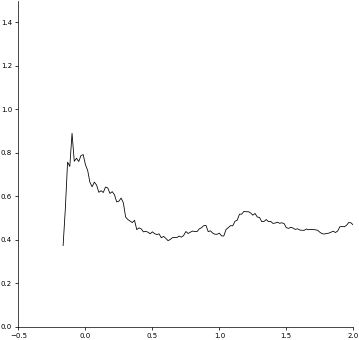

In [48]:
dt = hpf_new[1] - hpf_new[0]
fig1, ax1 = plt.subplots(figsize=(6,6))
# ax1.plot((np.arange(aligned_cov.shape[1])-np.max(new_offsets))*dt,aligned_cov[12,:])
ax1.plot((np.arange(aligned_cov.shape[1])-np.max(new_offsets))*dt,np.nanmean(aligned_cov, axis=0), color="k")
ax1.set_xlim(-0.5, 2)
ax1.set_ylim(0,1.5)

### Check relative amplitude of spikes

In [140]:
droi

mean_isi   std_isi  mean_prom  std_prom  mean_width  std_width  n_peaks  \
roi                                                                             
0.0        NaN       NaN        NaN       NaN         NaN        NaN      0.0   
0.0        NaN       NaN        NaN       NaN         NaN        NaN      0.0   
0.0        NaN       NaN        NaN       NaN         NaN        NaN      0.0   
0.0        NaN       NaN        NaN       NaN         NaN        NaN      0.0   
0.0        NaN       NaN        NaN       NaN         NaN        NaN      0.0   
...        ...       ...        ...       ...         ...        ...      ...   
15.0  5.382353  3.438354   0.012324  0.002392    0.861379   0.464429     20.0   
15.0  4.789916  3.331999   0.012434  0.002463    0.907640   0.457646     21.0   
15.0  4.781640  3.268336   0.012664  0.002759    1.001558   0.661748     22.0   
15.0  4.936275  3.245716   0.012674  0.002876    1.042397   0.679691     20.0   
15.0  5.046685  3.464707   0.012832  0.002858    1.097121   0.762354     21.0   

      pct95_dff  pct5_dff   max_dff   min_dff        offset        hpf  \
roi                                                                      
0.0         NaN       NaN       NaN       NaN      0.000000  19.000000   
0.0         NaN       NaN       NaN       NaN     11.764706  19.003268   
0.0         NaN       NaN       NaN       NaN     23.529412  19.006536   
0.0         NaN       NaN       NaN       NaN     35.294118  19.009804   
0.0         NaN       NaN       NaN       NaN     47.058824  19.013072   
...         ...       ...       ...       ...           ...        ...   
15.0   0.016077  0.009421  0.018353  0.009175  14164.705882  22.934641   
15.0   0.015957  0.009434  0.018353  0.009175  14176.470588  22.937908   
15.0   0.018216  0.009597  0.020122  0.009175  14188.235294  22.941176   
15.0   0.018441  0.009572  0.020122  0.009175  14200.000000  22.944444   
15.0   0.018353  0.009593  0.020122  0.009175  14211.764706  22.947712   

      mean_freq  
roi              
0.0    0.000000  
0.0    0.000000  
0.0    0.000000  
0.0    0.000000  
0.0    0.000000  
...         ...  
15.0   0.178791  
15.0   0.187730  
15.0   0.196670  
15.0   0.178791  
15.0   0.187730  

[19344 rows x 14 columns]

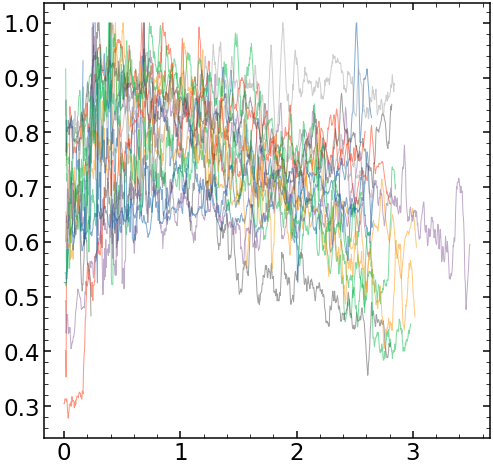

In [156]:
fig1, ax1 = plt.subplots(figsize=(8, 8))
for idx, roi in enumerate(rois):
    roi_data = droi.loc[roi]
    hpf_offset = dobj.start_hpf + offset_times[idx]/3600 - 0.05
    rel_prom = roi_data["mean_prom"].to_numpy()/np.nanmax(roi_data["mean_prom"])
#     print(rel_prom.shape)
#     print(roi_data["hpf"].shape)
#     print(hpf_offset.shape)
    hours = roi_data["hpf"].to_numpy() - hpf_offset
    idx_offset = np.argwhere(hours >= 0).ravel()[0]
    ax1.plot(hours[idx_offset:], rel_prom[idx_offset:], alpha=0.5)

### Plot ISI n vs ISI n+1

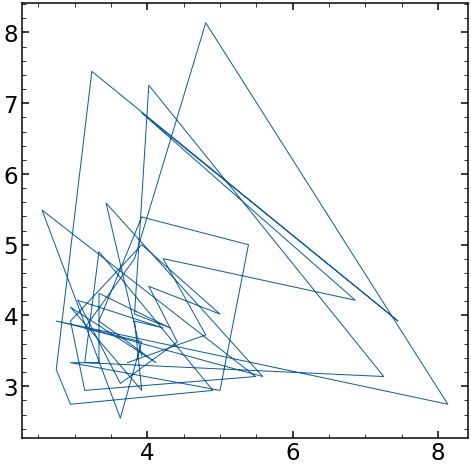

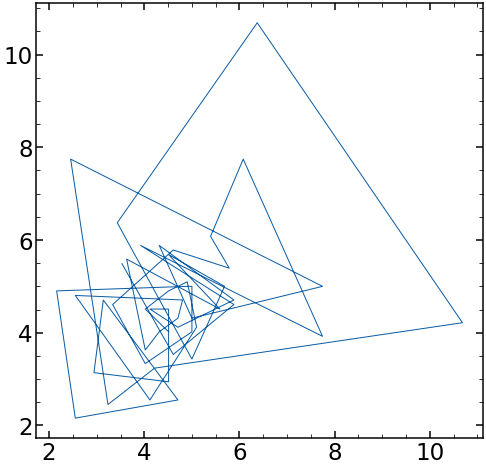

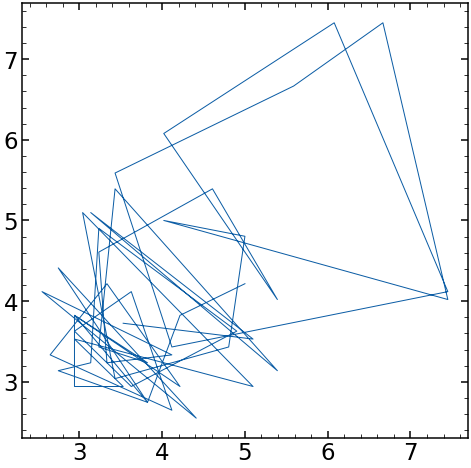

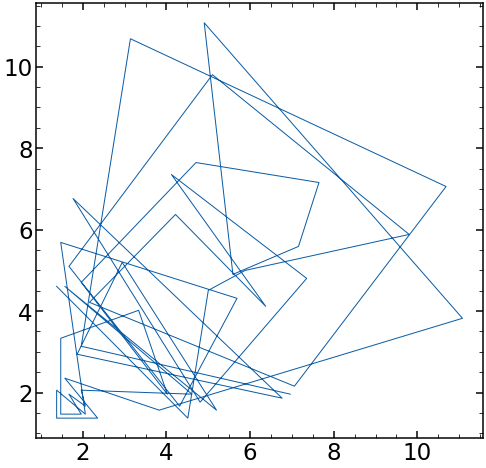

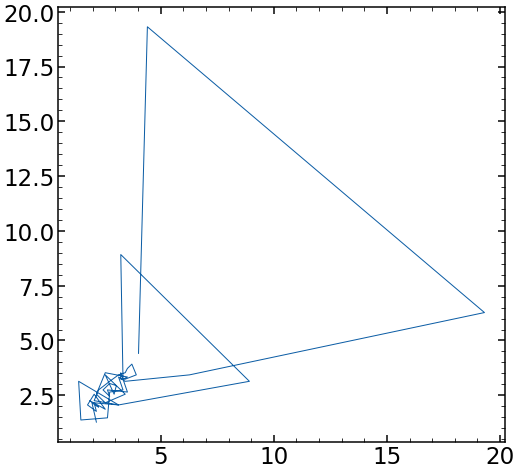

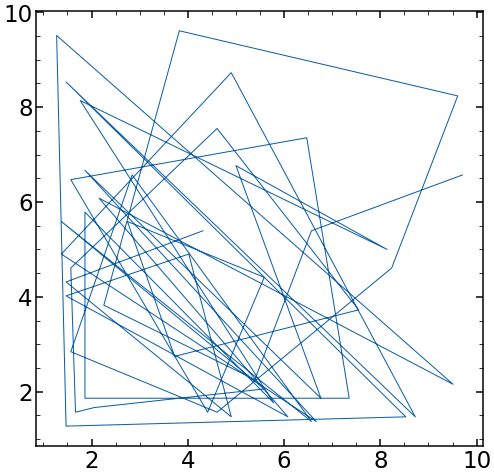

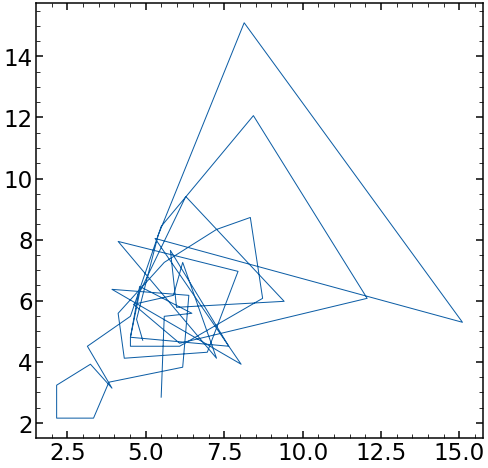

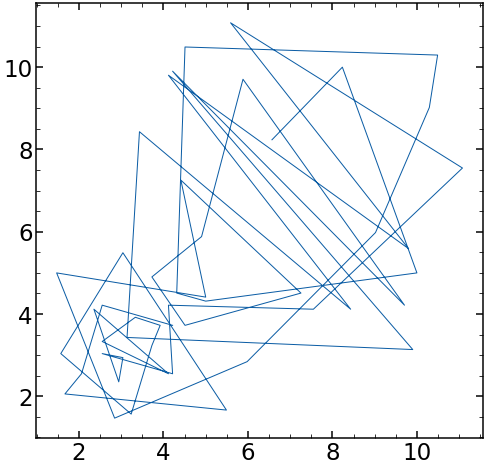

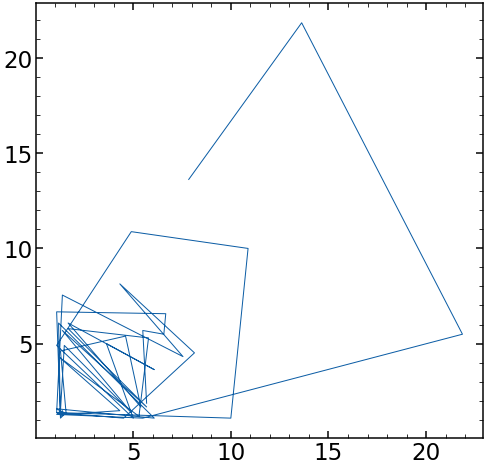

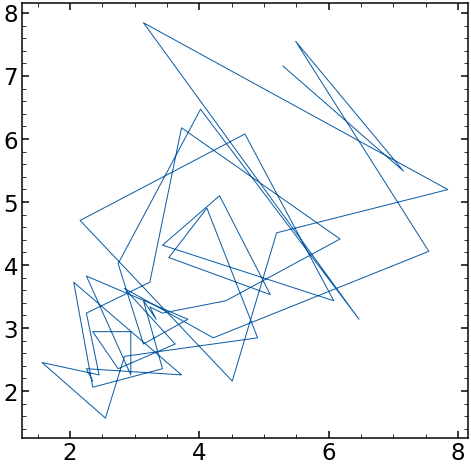

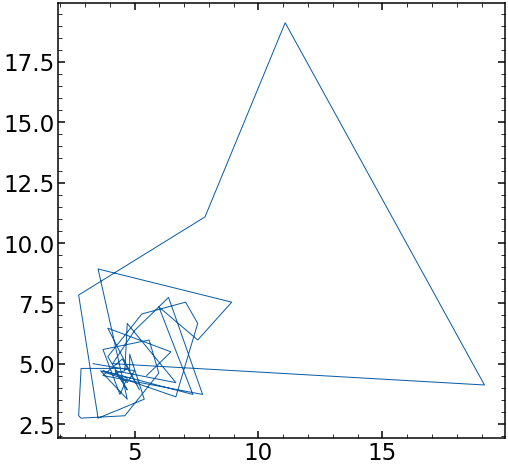

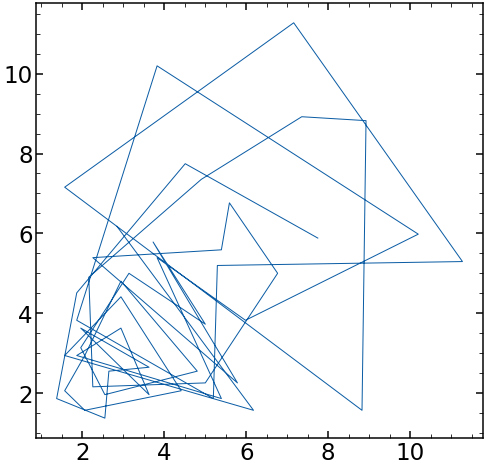

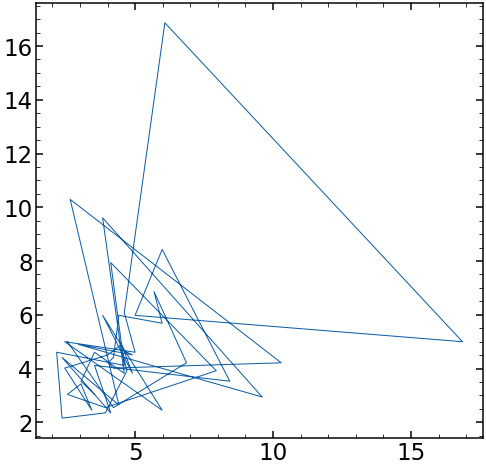

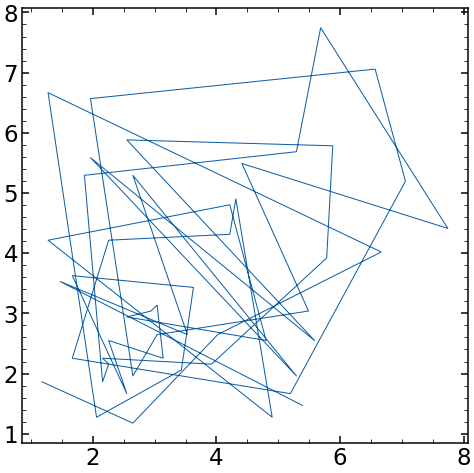

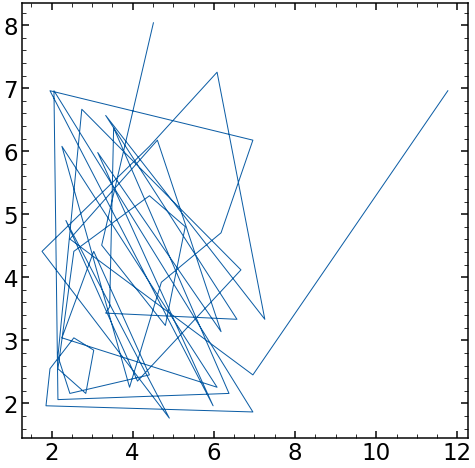

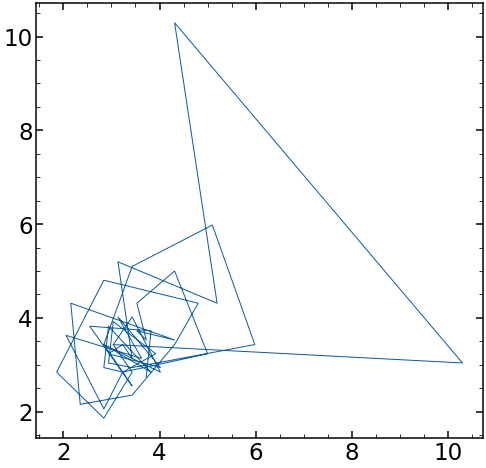

In [179]:
window_length = 50
start_idx = 500
for idx, roi in enumerate(rois):
    roi_data = dobj.peaks_data.loc[roi]
    isis = roi_data["isi"]
    isis = isis[start_idx:start_idx+window_length]
    axlim = np.percentile(isis[~np.isnan(isis)], 95) +10
    
    fig1, ax1 = plt.subplots(figsize=(8,8))
    ax1.plot(isis[:-1], isis[1:])
#     ax1.set_xlim((0, axlim))
#     ax1.set_ylim((0, axlim))

In [ ]:
window_length = 50
start_idx = 500
for idx, roi in enumerate(rois):
    roi_data = dobj.peaks_data.loc[roi]
    isis = roi_data["isi"]
    isis = isis[start_idx:start_idx+window_length]
    axlim = np.percentile(isis[~np.isnan(isis)], 95) +10
    
    fig1, ax1 = plt.subplots(figsize=(8,8))
    ax1.plot(isis[:-1], isis[1:])